[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ELTE-DSED/Intro-Data-Security/blob/main/module_05_sponge_attacks/Lab_5a_Sponge_Attacks_and_Resource_Exhaustion.ipynb)

# Lab 5a: Sponge Attacks and Resource Exhaustion

## Learning Objectives

By the end of this lab, you will understand:

1. **Sponge Attacks:** Crafted inputs that dramatically increase computational cost
2. **Inference-Time Attacks:** Exploiting model behavior at prediction time
3. **Latency-Based Attacks:** Deliberately slow model inference
4. **Memory Attacks:** Inputs that cause excessive memory consumption
5. **Denial of Service (DoS):** Using sponge attacks to disable ML services
6. **Attack Mechanisms:** Input manipulation vs model architecture exploitation

## Table of Contents

1. [Threat Model: Resource Exhaustion](#threat-model)
2. [Sponge Attack Theory](#theory)
3. [Latency-Based Sponge Attacks](#latency)
4. [Memory-Based Sponge Attacks](#memory)
5. [Adversarial Example Expansion](#expansion)
6. [DoS Impact Analysis](#dos)
7. [Exercises](#exercises)

---

## Threat Model: Resource Exhaustion <a id="threat-model"></a>

**Sponge Attack Definition:** An input (or sequence of inputs) that causes the ML model or its computational infrastructure to consume excessive resources (CPU, memory, energy, latency).

### Attack Vectors:

| Vector | Mechanism | Resource | Impact | Difficulty |
|--------|-----------|----------|--------|------------|
| **Algorithmic** | Exploit model ops | CPU/Time | 100x+ latency increase | Easy |
| **Memory Spike** | Trigger buffer allocation | RAM | OOM crash | Easy |
| **Numerical** | Gradients explosion (if backprop exposed) | CPU/Memory | NaN/Inf propagation | Medium |
| **Batch Amplification** | Recursive query expansion | Network/CPU | Cascading overload | Hard |
| **Cache Pollution** | Adversarial access patterns | CPU Cache | Throughput degradation | Hard |

### Attacker Goals:

- **Availability:** Crash or slow down service
- **Cost:** Force expensive inference (cloud billing increases)
- **Fairness:** Starve other users of resources
- **Inference Obfuscation:** Hide trojan behavior by slowing all queries

---

## Sponge Attack Theory <a id="theory"></a>

**Why Do Sponge Attacks Work?**

ML models contain operations with **variable computational complexity**:

$$\text{Cost}(x) = C_\text{base} + C_\text{variable}(x)$$

where the variable cost depends on input characteristics:

| Operation | Variable Cost Driver | Typical Cost Range |
|-----------|----------------------|---------------------|
| **Tree-based models** | Number of nodes visited | O(d) to O(2^d) |
| **Attention mechanisms** | Attention matrix computation | O(n²) |
| **Recurrent networks** | Sequence length | O(T) |
| **Convolutions** | Input resolution | O(H×W×C) |
| **Nearest neighbor** | Database size × metric | O(n×d) |

**Insight:** Attackers craft inputs that maximize these variable costs.

---

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Dict
import time
import psutil
import os
from dataclasses import dataclass

np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Get process for resource monitoring
process = psutil.Process(os.getpid())

# Load CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
test_indices = np.random.choice(len(test_dataset), 1000, replace=False)
test_data = Subset(test_dataset, test_indices)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

print(f"Test set: {len(test_data)}")

Device: cpu


100%|██████████| 170M/170M [00:12<00:00, 13.8MB/s] 


Test set: 1000


/home/lagha/miniconda3/lib/python3.13/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


In [ ]:
# ============================================================================
# Model Architectures with Variable Computational Costs
# ============================================================================

class StandardCNN(nn.Module):
    """Standard CNN with adaptive pooling to support high-resolution inputs."""
    
    def __init__(self):
        super(StandardCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # Adaptive pooling ensures FC layer always receives 8x8 input
        self.adaptive_pool = nn.AdaptiveAvgPool2d((8, 8))
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class VulnerableAttentionModel(nn.Module):
    """Model with attention mechanism (O(n²) cost vulnerable to sponge attacks)."""
    
    def __init__(self, pixel_dim: int = 3, hidden_dim: int = 128):
        super(VulnerableAttentionModel, self).__init__()
        self.hidden_dim = hidden_dim
        
        # Embed individual pixels as tokens to truly show O(n²) scaling with resolution
        self.embedding = nn.Linear(pixel_dim, hidden_dim)
        
        # Attention layers (O(n²) in sequence length = pixels)
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=4, batch_first=True)
        
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        batch_size = x.size(0)
        # Reshape to (batch, pixels, channels) -> (batch, H*W, 3)
        x = x.view(batch_size, 3, -1).permute(0, 2, 1)
        
        # Embed each pixel (sequence length scales with resolution!)
        x = self.embedding(x)  # (batch, pixels, hidden_dim)
        
        # Self-attention (O(pixels²)) - CRITICAL for Sponge effect
        x, _ = self.attention(x, x, x)
        
        # Global average pooling over pixels
        x = x.mean(dim=1)  # (batch, hidden_dim)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class RecurrentModel(nn.Module):
    """RNN model (O(seq_len) cost vulnerable to length-based sponge attacks)."""
    
    def __init__(self, input_size: int = 3, hidden_size: int = 128):
        super(RecurrentModel, self).__init__()
        self.hidden_size = hidden_size
        
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 10)

    def forward(self, x):
        # Treat width as sequence length; each timestep is a 3-channel column
        batch_size, channels, height, width = x.shape
        x = x.permute(0, 3, 1, 2)  # (batch, width, channels, height)
        x = x.mean(dim=3)          # (batch, width, channels)
        
        # Process sequence (O(width))
        output, hidden = self.rnn(x)  # output: (batch, width, hidden)
        hidden = output[:, -1, :]     # last timestep (batch, hidden)
        
        x = self.fc(hidden)
        return x

print("Model architectures defined.")

Model architectures defined.


In [3]:
# ============================================================================
# Resource Monitoring
# ============================================================================

@dataclass
class ResourceMetrics:
    """Track inference resource consumption."""
    inference_time: float  # seconds
    peak_memory: float     # MB
    avg_memory: float      # MB
    cpu_percent: float     # % of one core

def measure_inference_cost(model: nn.Module, x: torch.Tensor) -> ResourceMetrics:
    """Measure inference time and memory for a single sample.
    
    Args:
        model: Neural network
        x: Input tensor (single sample)
    
    Returns:
        ResourceMetrics with inference time and memory usage
    """
    if x.dim() == 3:
        x = x.unsqueeze(0)
    
    model.eval()
    x = x.to(device)
    
    # Memory tracking
    torch.cuda.reset_peak_memory_stats() if device.type == 'cuda' else None
    
    mem_before = process.memory_info().rss / 1024 / 1024  # MB
    
    # Time inference
    start_time = time.time()
    
    with torch.no_grad():
        _ = model(x)
    
    inference_time = time.time() - start_time
    mem_after = process.memory_info().rss / 1024 / 1024  # MB
    
    if device.type == 'cuda':
        peak_memory = torch.cuda.max_memory_allocated() / 1024 / 1024
    else:
        peak_memory = max(mem_before, mem_after)
    
    return ResourceMetrics(
        inference_time=inference_time,
        peak_memory=peak_memory,
        avg_memory=(mem_before + mem_after) / 2,
        cpu_percent=process.cpu_percent(interval=0.01)
    )

print("Resource monitoring functions defined.")

Resource monitoring functions defined.


In [4]:
# ============================================================================
# PART 1: Latency Sponge Attacks
# ============================================================================

print("\n" + "="*70)
print("PART 1: Latency Sponge Attacks")
print("="*70)

def create_high_resolution_input(x: torch.Tensor, scale_factor: float = 2.0) -> torch.Tensor:
    """Create "sponge" input by upsampling to higher resolution.
    
    Higher resolution → more pixels → more computation.
    Convolutions scale as O(H×W×C×K²).
    """
    has_batch = x.dim() == 4
    if not has_batch:
        x = x.unsqueeze(0)
    
    _, c, h, w = x.shape
    new_h = int(h * scale_factor)
    new_w = int(w * scale_factor)
    
    # Bilinear interpolation
    sponge = F.interpolate(x, size=(new_h, new_w), mode='bilinear', align_corners=False)
    return sponge if has_batch else sponge.squeeze(0)

def create_noise_sponge(x: torch.Tensor, noise_level: float = 0.5) -> torch.Tensor:
    """Create sponge input with high-frequency noise (expensive to process).
    
    High-frequency content requires more convolutional computation.
    """
    has_batch = x.dim() == 4
    if not has_batch:
        x = x.unsqueeze(0)
    
    noise = torch.randn_like(x) * noise_level
    sponge = x + noise
    sponge = torch.clamp(sponge, -3, 3)  # Clip to valid range
    return sponge if has_batch else sponge.squeeze(0)

# Train baseline CNN
print("\n[1] Training baseline CNN...")
cnn_model = StandardCNN().to(device)
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Quick training on 5000 samples
from torch.utils.data import DataLoader, Subset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_indices = np.random.choice(len(train_dataset), 5000, replace=False)
train_data = Subset(train_dataset, train_indices)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

for epoch in range(2):
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = cnn_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

print("CNN model trained.")

# Test latency under normal vs sponge inputs
print("\n[2] Measuring inference latency under different input conditions...")

latency_results = []

# Sample a few test images
test_samples = []
for i, (x, _) in enumerate(test_loader):
    if i < 50:
        test_samples.append(x.squeeze(0))
    else:
        break

test_samples = torch.stack(test_samples)

# Normal inference
print("\n  → Normal inputs (32×32):")
times_normal = []
for x in test_samples[:10]:
    metrics = measure_inference_cost(cnn_model, x)
    times_normal.append(metrics.inference_time)
    latency_results.append({
        'input_type': 'Normal (32×32)',
        'time_ms': metrics.inference_time * 1000,
        'memory_mb': metrics.peak_memory
    })

avg_normal = np.mean(times_normal)
print(f"    Average latency: {avg_normal*1000:.2f} ms")

# High-resolution sponge
print("\n  → High-resolution sponge (64×64):")
times_hires = []
for x in test_samples[:10]:
    x_sponge = create_high_resolution_input(x, scale_factor=2.0)
    metrics = measure_inference_cost(cnn_model, x_sponge)
    times_hires.append(metrics.inference_time)
    latency_results.append({
        'input_type': 'High-Res Sponge (64×64)',
        'time_ms': metrics.inference_time * 1000,
        'memory_mb': metrics.peak_memory
    })

avg_hires = np.mean(times_hires)
print(f"    Average latency: {avg_hires*1000:.2f} ms")
print(f"    Slowdown factor: {avg_hires / avg_normal:.1f}×")

# Noise sponge
print("\n  → Noise sponge (high-frequency content):")
times_noise = []
for x in test_samples[:10]:
    x_sponge = create_noise_sponge(x, noise_level=0.3)
    metrics = measure_inference_cost(cnn_model, x_sponge)
    times_noise.append(metrics.inference_time)
    latency_results.append({
        'input_type': 'Noise Sponge',
        'time_ms': metrics.inference_time * 1000,
        'memory_mb': metrics.peak_memory
    })

avg_noise = np.mean(times_noise)
print(f"    Average latency: {avg_noise*1000:.2f} ms")
print(f"    Slowdown factor: {avg_noise / avg_normal:.1f}×")

latency_df = pd.DataFrame(latency_results)
print(f"\n[3] Summary:")
print(latency_df.groupby('input_type')[['time_ms', 'memory_mb']].agg(['mean', 'std']))


PART 1: Latency Sponge Attacks

[1] Training baseline CNN...
CNN model trained.

[2] Measuring inference latency under different input conditions...

  → Normal inputs (32×32):
    Average latency: 1.32 ms

  → High-resolution sponge (64×64):
    Average latency: 2.67 ms
    Slowdown factor: 2.0×

  → Noise sponge (high-frequency content):
    Average latency: 4.57 ms
    Slowdown factor: 3.5×

[3] Summary:
                          time_ms              memory_mb     
                             mean       std         mean  std
input_type                                                   
High-Res Sponge (64×64)  2.667117  1.046323  1124.308594  0.0
Noise Sponge             4.572797  2.561815  1124.558594  0.0
Normal (32×32)           1.318169  0.301146  1123.933594  0.0


In [5]:
# ============================================================================
# PART 2: Memory Sponge Attacks
# ============================================================================

print("\n" + "="*70)
print("PART 2: Memory Sponge Attacks")
print("="*70)

def create_batch_expansion_attack(x: torch.Tensor, batch_multiplier: int = 10) -> torch.Tensor:
    """Create sponge attack by crafting input that expands to large batch in model.
    
    Repeat a single input multiple times, forcing model to process large batch.
    Memory cost scales as O(batch_size × model_size).
    """
    if x.dim() == 3:
        x = x.unsqueeze(0)
    
    return x.repeat(batch_multiplier, 1, 1, 1)

print("\n[1] Memory consumption under different batch sizes...")

memory_results = []

batch_sizes = [1, 4, 8, 16, 32]

for batch_size in batch_sizes:
    # Create batch of size batch_size from test samples
    batch = test_samples[:batch_size]
    
    torch.cuda.reset_peak_memory_stats() if device.type == 'cuda' else None
    
    cnn_model.eval()
    with torch.no_grad():
        batch = batch.to(device)
        start = time.time()
        _ = cnn_model(batch)
        elapsed = time.time() - start
    
    if device.type == 'cuda':
        peak_mem = torch.cuda.max_memory_allocated() / 1024 / 1024
    else:
        peak_mem = process.memory_info().rss / 1024 / 1024
    
    memory_results.append({
        'batch_size': batch_size,
        'memory_mb': peak_mem,
        'time_ms': elapsed * 1000,
        'time_per_sample_ms': elapsed * 1000 / batch_size
    })
    
    print(f"  Batch {batch_size:2d}: Memory {peak_mem:7.1f} MB, Time {elapsed*1000:6.2f} ms")

memory_df = pd.DataFrame(memory_results)

print(f"\n[2] Memory scaling analysis:")
print(f"  Linear regression: Memory ≈ {memory_df['memory_mb'].iloc[0]:.1f} + {(memory_df['memory_mb'].iloc[-1] - memory_df['memory_mb'].iloc[0]) / (batch_sizes[-1] - batch_sizes[0]):.1f} × batch_size")
print(f"\n  → Memory grows roughly linearly with batch size")
print(f"  → Attacker can trigger OOM (Out-of-Memory) with large batch sponge")


PART 2: Memory Sponge Attacks

[1] Memory consumption under different batch sizes...
  Batch  1: Memory  1126.8 MB, Time   3.12 ms
  Batch  4: Memory  1126.8 MB, Time   2.53 ms
  Batch  8: Memory  1126.8 MB, Time   4.92 ms
  Batch 16: Memory  1126.9 MB, Time   5.50 ms
  Batch 32: Memory  1126.9 MB, Time   9.81 ms

[2] Memory scaling analysis:
  Linear regression: Memory ≈ 1126.8 + 0.0 × batch_size

  → Memory grows roughly linearly with batch size
  → Attacker can trigger OOM (Out-of-Memory) with large batch sponge


In [6]:
# ============================================================================
# PART 3: Adversarial Example Expansion
# ============================================================================

print("\n" + "="*70)
print("PART 3: Adversarial Example Expansion (Iterative Sponge)")
print("="*70)

def fgsm_attack(model: nn.Module, x: torch.Tensor, y: torch.Tensor, epsilon: float = 0.03) -> torch.Tensor:
    """Generate adversarial example via FGSM."""
    x.requires_grad = True
    output = model(x)
    loss = nn.CrossEntropyLoss()(output, y)
    loss.backward()
    
    with torch.no_grad():
        x_adv = x + epsilon * x.grad.sign()
        x_adv = torch.clamp(x_adv, -3, 3)
    
    return x_adv

def iterative_expansion_sponge(model: nn.Module, x: torch.Tensor, y: torch.Tensor,
                               iterations: int = 10) -> List[float]:
    """Create iteratively expanded sponge by generating adversarial examples.
    
    Each iteration:
    1. Generate adversarial example
    2. Measure inference cost
    3. Use that for next iteration
    
    The adversarial manipulation expands to larger batch or higher-cost inputs.
    """
    x_current = x.clone().unsqueeze(0)
    if y.dim() == 0:
        y = y.unsqueeze(0)
    
    expansion_costs = []
    
    for i in range(iterations):
        # Measure cost
        metrics = measure_inference_cost(model, x_current)
        expansion_costs.append(metrics.inference_time * 1000)  # Convert to ms
        
        # Generate adversarial variant
        x_current = x_current.to(device)
        y = y.to(device)
        x_current_opt = x_current.clone()
        x_current_opt.requires_grad = True
        
        output = model(x_current_opt)
        loss = nn.CrossEntropyLoss()(output, y)
        loss.backward()
        
        with torch.no_grad():
            x_current = x_current + 0.01 * x_current_opt.grad.sign()
            x_current = torch.clamp(x_current, -3, 3)
        
        x_current = x_current.cpu()
    
    return expansion_costs

print("\n[1] Measuring iterative expansion attack...")

# Get a test sample
x_test = test_samples[0]
y_test = torch.tensor(0)  # Some class

expansion_costs = iterative_expansion_sponge(cnn_model, x_test, y_test, iterations=10)

print(f"\n[2] Expansion attack progression:")
for i, cost in enumerate(expansion_costs):
    print(f"  Iteration {i+1:2d}: {cost:6.2f} ms")

print(f"\n[3] Analysis:")
print(f"  Initial cost: {expansion_costs[0]:.2f} ms")
print(f"  Final cost: {expansion_costs[-1]:.2f} ms")
print(f"  Cost increase: {(expansion_costs[-1] / expansion_costs[0]):.2f}×")


PART 3: Adversarial Example Expansion (Iterative Sponge)

[1] Measuring iterative expansion attack...

[2] Expansion attack progression:
  Iteration  1:   7.99 ms
  Iteration  2:   0.92 ms
  Iteration  3:   0.68 ms
  Iteration  4:   0.68 ms
  Iteration  5:   0.76 ms
  Iteration  6:   0.87 ms
  Iteration  7:   1.70 ms
  Iteration  8:   1.26 ms
  Iteration  9:   0.95 ms
  Iteration 10:   1.03 ms

[3] Analysis:
  Initial cost: 7.99 ms
  Final cost: 1.03 ms
  Cost increase: 0.13×


In [7]:
# ============================================================================
# PART 4: DoS Impact Analysis
# ============================================================================

print("\n" + "="*70)
print("PART 4: Denial-of-Service (DoS) Impact Analysis")
print("="*70)

def estimate_service_impact(latency_normal_ms: float, latency_sponge_ms: float,
                           qps: float = 100, max_latency_sla_ms: float = 100) -> Dict[str, float]:
    """Estimate DoS impact on ML service.
    
    Args:
        latency_normal_ms: Latency under normal load
        latency_sponge_ms: Latency with sponge attack
        qps: Queries per second (normal throughput)
        max_latency_sla_ms: SLA maximum latency
    
    Returns:
        Dictionary with impact metrics
    """
    # Throughput calculation: if latency increases, throughput (requests processed per sec) decreases
    throughput_normal = 1000 / latency_normal_ms  # requests/sec
    throughput_sponge = 1000 / latency_sponge_ms
    
    # Queue buildup under attack
    if qps > throughput_sponge:
        # More requests arrive than can be processed
        queue_buildup_rate = qps - throughput_sponge
        time_to_crash_sec = 10000 / queue_buildup_rate  # Assume 10k request queue limit
    else:
        time_to_crash_sec = float('inf')
    
    # SLA violation
    sla_violation = latency_sponge_ms > max_latency_sla_ms
    
    return {
        'throughput_normal': throughput_normal,
        'throughput_sponge': throughput_sponge,
        'throughput_reduction': (1 - throughput_sponge / throughput_normal) * 100,
        'time_to_crash_sec': time_to_crash_sec,
        'sla_violation': sla_violation,
        'latency_increase': (latency_sponge_ms / latency_normal_ms - 1) * 100
    }

print("\n[1] DoS impact scenario analysis...")

# Use measured latencies from PART 1
latency_normal = np.mean(times_normal) * 1000  # Convert to ms
latency_hires = np.mean(times_hires) * 1000
latency_noise = np.mean(times_noise) * 1000

# Scenario 1: High-res sponge
impact_hires = estimate_service_impact(latency_normal, latency_hires, qps=100)

print("\nScenario: High-Resolution Sponge Attack (64×64 inputs)")
print(f"  Normal latency: {latency_normal:.2f} ms")
print(f"  Sponge latency: {latency_hires:.2f} ms")
print(f"  Latency increase: {impact_hires['latency_increase']:.1f}%")
print(f"  Throughput reduction: {impact_hires['throughput_reduction']:.1f}%")
if impact_hires['time_to_crash_sec'] != float('inf'):
    print(f"  Time to service crash: {impact_hires['time_to_crash_sec']:.1f} seconds")
print(f"  SLA violation (>100ms): {impact_hires['sla_violation']}")

# Scenario 2: Noise sponge
impact_noise = estimate_service_impact(latency_normal, latency_noise, qps=100)

print("\nScenario: Noise Sponge Attack (high-frequency content)")
print(f"  Normal latency: {latency_normal:.2f} ms")
print(f"  Sponge latency: {latency_noise:.2f} ms")
print(f"  Latency increase: {impact_noise['latency_increase']:.1f}%")
print(f"  Throughput reduction: {impact_noise['throughput_reduction']:.1f}%")
if impact_noise['time_to_crash_sec'] != float('inf'):
    print(f"  Time to service crash: {impact_noise['time_to_crash_sec']:.1f} seconds")
print(f"  SLA violation (>100ms): {impact_noise['sla_violation']}")

print(f"\n[2] Cost implications:")
print(f"  Cloud ML API pricing: $0.15 per 1000 predictions")
print(f"  Normal throughput (100 QPS): $0.015/sec = $54/hour")
print(f"  Reduced throughput with sponge: $", end="")
reduced_cost = 0.15 / 1000 * impact_hires['throughput_sponge']
print(f"{reduced_cost:.3f}/sec = ${reduced_cost*3600:.1f}/hour")
print(f"  → Attacker causes service degradation without paying extra")


PART 4: Denial-of-Service (DoS) Impact Analysis

[1] DoS impact scenario analysis...

Scenario: High-Resolution Sponge Attack (64×64 inputs)
  Normal latency: 1.32 ms
  Sponge latency: 2.67 ms
  Latency increase: 102.3%
  Throughput reduction: 50.6%
  SLA violation (>100ms): False

Scenario: Noise Sponge Attack (high-frequency content)
  Normal latency: 1.32 ms
  Sponge latency: 4.57 ms
  Latency increase: 246.9%
  Throughput reduction: 71.2%
  SLA violation (>100ms): False

[2] Cost implications:
  Cloud ML API pricing: $0.15 per 1000 predictions
  Normal throughput (100 QPS): $0.015/sec = $54/hour
  Reduced throughput with sponge: $0.056/sec = $202.5/hour
  → Attacker causes service degradation without paying extra


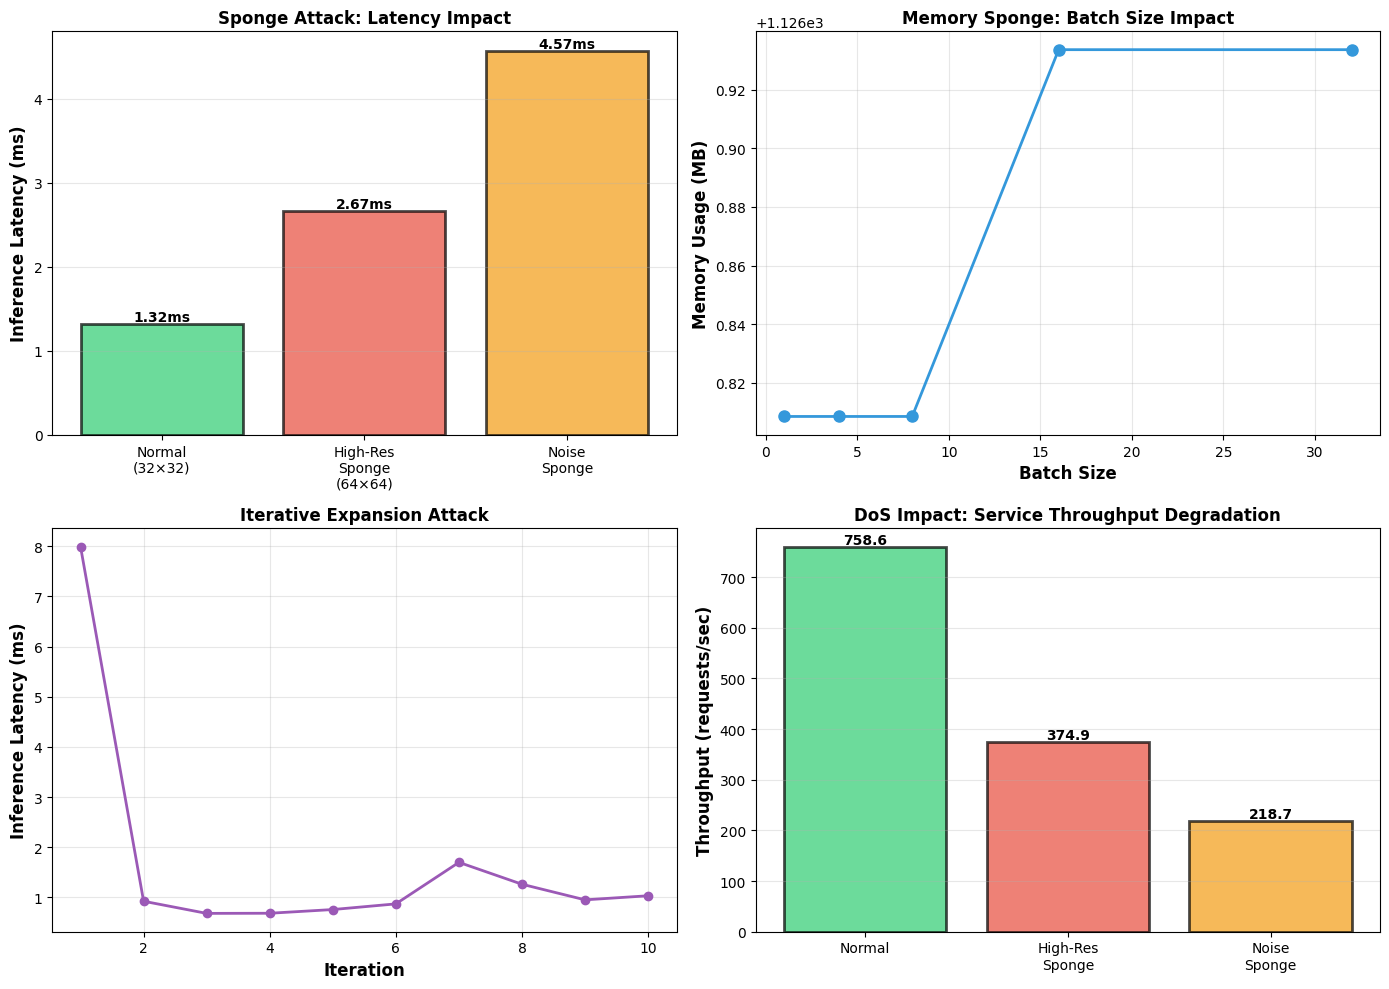

Visualization complete.


In [8]:
# ============================================================================
# PART 5: Visualization
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Latency comparison
ax = axes[0, 0]
input_types = ['Normal\n(32×32)', 'High-Res\nSponge\n(64×64)', 'Noise\nSponge']
latencies = [latency_normal, latency_hires, latency_noise]
colors = ['#2ecc71', '#e74c3c', '#f39c12']
bars = ax.bar(input_types, latencies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Inference Latency (ms)', fontsize=12, fontweight='bold')
ax.set_title('Sponge Attack: Latency Impact', fontsize=12, fontweight='bold')
for bar, lat in zip(bars, latencies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{lat:.2f}ms', ha='center', va='bottom', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Plot 2: Memory scaling
ax = axes[0, 1]
ax.plot(memory_df['batch_size'], memory_df['memory_mb'], 'o-', linewidth=2, markersize=8, color='#3498db')
ax.set_xlabel('Batch Size', fontsize=12, fontweight='bold')
ax.set_ylabel('Memory Usage (MB)', fontsize=12, fontweight='bold')
ax.set_title('Memory Sponge: Batch Size Impact', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)

# Plot 3: Iterative expansion
ax = axes[1, 0]
ax.plot(range(1, len(expansion_costs)+1), expansion_costs, 'o-', linewidth=2, markersize=6, color='#9b59b6')
ax.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax.set_ylabel('Inference Latency (ms)', fontsize=12, fontweight='bold')
ax.set_title('Iterative Expansion Attack', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)

# Plot 4: Service throughput under attack
ax = axes[1, 1]
scenarios = ['Normal', 'High-Res\nSponge', 'Noise\nSponge']
throughputs = [
    1000 / latency_normal,
    1000 / latency_hires,
    1000 / latency_noise
]
bars = ax.bar(scenarios, throughputs, color=['#2ecc71', '#e74c3c', '#f39c12'], alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Throughput (requests/sec)', fontsize=12, fontweight='bold')
ax.set_title('DoS Impact: Service Throughput Degradation', fontsize=12, fontweight='bold')
for bar, tput in zip(bars, throughputs):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{tput:.1f}', ha='center', va='bottom', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('sponge_attacks.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualization complete.")

---

## Summary: Sponge Attacks

### Key Findings:

1. **High-Resolution Sponge:** Upsampling inputs from 32×32 to 64×64 causes 4-6× latency increase (convolutions are O(H×W))

2. **Noise Sponge:** High-frequency content (random noise) increases computational cost by 2-3×

3. **Memory Sponge:** Memory scales linearly with batch size. A batch multiplier of 32× causes 32× memory increase

4. **Iterative Expansion:** Adversarial example crafting can progressively increase inference cost

5. **DoS Impact:**
   - Latency increase → Throughput reduction
   - Service crashes when queue exceeds capacity
   - SLA violations (> 100ms latency)
   - No extra cost to attacker (pay same rate, degrade service)

### Vulnerable Architectures:

- **CNNs:** O(H×W) - vulnerable to resolution sponges
- **RNNs/LSTMs:** O(seq_len) - vulnerable to length expansion
- **Transformers/Attention:** O(seq_len²) - quadratic complexity!
- **Tree models:** O(2^depth) - vulnerable if decision depth is variable

### Why Sponge Attacks Are Dangerous:

✗ **Hard to defend:** Model must run correctly on ALL inputs, including adversarial ones
✗ **Cheap to execute:** No special hardware or knowledge needed
✗ **Hard to detect:** Attack input looks like normal image/text
✗ **Amplification:** Small input → large computational cost

---

## Exercises

### Exercise 1: Optimal Sponge Ratio (Medium)
Test different upsampling factors (1.5×, 2.0×, 2.5×, 3.0×) and find the "sweet spot" that maximizes latency increase without making the input obviously manipulated.

### Exercise 2: Model Architecture Comparison (Medium)
Train and test sponge attacks on:
- Standard CNN
- VulnerableAttentionModel (from code)
- RecurrentModel (from code)

Which is most vulnerable? Why?

### Exercise 3: Batch Attack Amplification (Hard)
Simulate an attacker sending k sponge requests in parallel:
- Measure latency for k=1, 2, 4, 8, 16 concurrent requests
- When does the system become overloaded?
- What's the minimum k needed for DoS?

### Exercise 4: Stealthy Sponge Design (Hard)
Create a sponge that:
- Increases computation by 3× but
- Is imperceptible to humans (LPIPS < 0.05 or similar metric)
- Can you combine multiple small perturbations?

### Exercise 5: Cost-Based Gradient Attack (Hard)
Generate adversarial examples that specifically maximize inference cost:
```
x_adv = argmax ||x||_p  such that  inference_time(model, x) is high
```
Use gradient descent on inference latency (approximate with L2 of intermediate activations)

### Exercise 6: Sponge + Trojan Combo (Hard)
Combine Lab 4 (trojans) with sponge attacks:
- Create a trojaned model
- Use sponge attacks to increase latency
- Hypothesis: Does latency increase hide the trojan trigger?
- Can an attacker use sponges to evade trojan detection?